In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sy
import seaborn as sns
%matplotlib inline

The dataset for this project comes from sp_500_Aggregated.csv file. This file is a result of SQL Server aggregation of 4 datasets using the following methodology:

a) Historical S&P 500 data from finance.yahoo.com has been used as a base

b) Mercury Retrograde calendar from astrologymiami.com has been used to assign Mercury Retrograde Degree to each date in S&P 500 data. The dataset contains two variables for Mercury Retrograde Degree: the Collapsed variable does not distinquish between Pre-Retrograde and Post-Retrograde shadow dates, as well as Direct and Reverse Stations, and assigns them to the same category, based on the supposed intensity, while the Granual variable assigns different categies to each Pre-Retrograde and Post-etrograde shadow dates.

c) FOMC meetings calendar from federalreserve.gov has been used to assign Federal Reserve Conference to each date. This variable is used as a control variable since these meetings are expected to have an effect on the market.

d) Historical VIX (S&P 500 volatility index) from finance.yahoo.com has been added to the base dataset joining on the  Date field

e) The following variables were added to S&P 500 and VIX data for each Date: 1. SP500_HighLow_Delta and VIX_HighLow_Delta, calculated as the difference between the date's High and Low values 2. SP500_HighLow_Delta_Percent and VIX_HighLow_Delta_Percent, calculated as the percentage of High/Low delta over the Low value 3. SP500_OpenClose_Delta and VIX_OpenClose_Delta, calculated as the difference between the date's Open and the previous date's Close 4. SP500_OpenClose_Delta_Percent and VIX_OpenClose_Delta_Percent, calculated as the perentage of Open/Close delta over the Close value 5. SP500_DeltaPercent_Combined and VIX_DeltaPErcent_Combined, calculated as the sum of absolute values of HighLow and OpenClose percentages. These variables will be the main dependent variables researched in this project.

f) Given that S&P 500 data is only available when the market is open, while Mercury retrograde degree changes may occur on weekends and holidays, the missing date records were added, imputing the S&P 500 variables with the averages of the two records, between which they were inserted. RecordImputedFlag value Y indicates the imputed records.

g) Since the Mercury retrograde calendar starts in July of 2011, Only the dates 5/5/2011 or later were included in the file


In [2]:
#read the data from the file
#df_raw = pd.read_csv('/Users/albinamorozova/Downloads/sp_500_Aggregated.csv')
df_raw = pd.read_csv('sp_500_Aggregated.csv')
df_raw.head()

,Date,RecordImputedFlag,Mercury_Retrograde_Degree_Colapsed,Mercury_Retrograde_Degree_Granular,Mercury_Retrograde_Degree_Description,FedReserveConference,FedReserveConference_Description,SP500_Open,SP500_High,SP500_Low,...,VIX_Open,VIX_High,VIX_Low,VIX_Close,VIX_Adj Close,VIX_HighLow_Delta,VIX_HighLow_Delta_Percent,VIX_OpenClose_Delta,VIX_OpenClose_Delta_Percent,VIX_DeltaPErcent_Combined
0,5/5/2011,N,0,0,No Retrograde,0,No Conference,1344.160034,1348.000000,1329.170044,...,17.68,19.110001,16.740000,18.200001,18.200001,2.370001,14.157712,0.600000,3.512881,17.670593
1,5/6/2011,N,0,0,No Retrograde,0,No Conference,1340.239990,1354.359985,1335.579956,...,17.17,19.290001,16.120001,18.400000,18.400000,3.170000,19.665011,-1.030001,-5.659346,25.324357
2,5/7/2011,Y,0,0,No Retrograde,0,No Conference,1340.219971,1351.899963,1337.109986,...,17.88,18.940001,16.580001,17.780000,17.780000,2.359999,14.380624,-0.420000,-2.313369,17.726602
3,5/8/2011,Y,0,0,No Retrograde,0,No Conference,1340.219971,1351.899963,1337.109986,...,17.88,18.940001,16.580001,17.780000,17.780000,2.359999,14.380624,-0.420000,-2.313369,17.726602
4,5/9/2011,N,0,0,No Retrograde,0,No Conference,1340.199951,1349.439941,1338.640015,...,18.59,18.590000,17.040001,17.160000,17.160000,1.549999,9.096238,0.190000,1.032609,10.128846


In [3]:
df_raw.describe()

,Mercury_Retrograde_Degree_Colapsed,Mercury_Retrograde_Degree_Granular,FedReserveConference,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_AdjClose,SP500_Volume,SP500_HighLow_Delta,...,VIX_Open,VIX_High,VIX_Low,VIX_Close,VIX_Adj Close,VIX_HighLow_Delta,VIX_HighLow_Delta_Percent,VIX_OpenClose_Delta,VIX_OpenClose_Delta_Percent,VIX_DeltaPErcent_Combined
count,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2.452000e+03,2452.000000,...,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000
mean,1.247553,2.051794,0.036705,1865.181465,1873.381295,1856.356752,1865.667726,1865.667726,3.581324e+09,17.024543,...,16.255436,17.030471,15.509056,16.146501,16.146501,1.521415,9.489855,0.126399,0.930839,12.960666
std,1.730134,2.879777,0.257643,397.894470,397.279820,398.617309,398.094789,398.094789,7.031179e+08,9.901677,...,5.681726,6.134058,5.305855,5.706031,5.706031,1.327145,5.838396,0.883625,4.447552,7.455451
min,0.000000,0.000000,0.000000,1097.420044,1125.119995,1074.770020,1099.229980,1099.229980,0.000000e+00,3.699951,...,9.010000,9.310000,8.560000,9.140000,9.140000,0.239999,1.143942,-9.610003,-23.588617,2.648419
25%,0.000000,0.000000,0.000000,1462.876236,1470.070008,1458.944992,1464.179993,1464.179993,3.151215e+09,10.459961,...,12.800000,13.280000,12.320000,12.670000,12.670000,0.800000,5.974855,-0.200000,-1.375061,8.260672
50%,0.000000,0.000000,0.000000,1940.815002,1952.494995,1927.430054,1940.895020,1940.895020,3.507155e+09,14.440125,...,14.735000,15.430000,14.040000,14.610000,14.610000,1.180000,8.108757,0.085000,0.654099,11.255609
75%,2.000000,3.000000,0.000000,2108.054932,2115.535034,2099.389954,2109.559937,2109.559937,3.922819e+09,20.750000,...,17.772500,18.639999,16.925000,17.762500,17.762500,1.800000,11.125351,0.410000,2.803274,15.346294
max,5.000000,8.000000,3.000000,2802.600098,2810.330078,2798.080078,2810.300049,2810.300049,7.597450e+09,98.140014,...,46.180000,53.290001,41.509998,48.000000,48.000000,25.260000,90.117728,8.809999,51.072458,90.117728


In [4]:
df_raw.count()

Date                                     2452
RecordImputedFlag                        2452
Mercury_Retrograde_Degree_Colapsed       2452
Mercury_Retrograde_Degree_Granular       2452
Mercury_Retrograde_Degree_Description    2452
FedReserveConference                     2452
FedReserveConference_Description         2452
SP500_Open                               2452
SP500_High                               2452
SP500_Low                                2452
SP500_Close                              2452
SP500_AdjClose                           2452
SP500_Volume                             2452
SP500_HighLow_Delta                      2452
SP500_HighLow_Delta_Percent              2452
SP500_OpenClose_Delta                    2452
SP500_OpenClose_Delta_Percent            2452
SP500_DeltaPercent_Combined              2452
VIX_Open                                 2452
VIX_High                                 2452
VIX_Low                                  2452
VIX_Close                         

In [15]:
df_raw['Mercury_Retrograde_Degree_Description'].value_counts()

No Retrograde              1253
Preshadow                   273
Retrograde                  273
Postshadow                  268
Retrograde Intensified      166
Postshadow Intensified       84
Preshadow Intensified        84
Retrograde Station           28
Direct Station               23
Name: Mercury_Retrograde_Degree_Description, dtype: int64

In [18]:
df_raw['FedReserveConference_Description'].value_counts()

No Conference                       2396
Scheduled Non-Summary Conference      26
Scheduled Summary Conference          26
Unscheduled Conference                 4
Name: FedReserveConference_Description, dtype: int64

As we can see from the results of describe and count methods, out dataset has 2452 records where all variables have values. The number of observations where there is no any sort of Mercury Retrograde stage is over 50 percent of the dataset, the number of observations where there was no Federal Reserve conference is about 95 percent of the dataset.

In [5]:
#Examine the variable correlations
df_raw.corr()

,Mercury_Retrograde_Degree_Colapsed,Mercury_Retrograde_Degree_Granular,FedReserveConference,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_AdjClose,SP500_Volume,SP500_HighLow_Delta,...,VIX_Open,VIX_High,VIX_Low,VIX_Close,VIX_Adj Close,VIX_HighLow_Delta,VIX_HighLow_Delta_Percent,VIX_OpenClose_Delta,VIX_OpenClose_Delta_Percent,VIX_DeltaPErcent_Combined
Mercury_Retrograde_Degree_Colapsed,1.000000,0.993342,0.018050,0.005532,0.007330,0.004236,0.005764,0.005764,0.036125,0.123587,...,0.077471,0.080753,0.070660,0.073335,0.073335,0.090745,0.065083,-0.037049,-0.036181,0.075108
Mercury_Retrograde_Degree_Granular,0.993342,1.000000,0.020532,0.003533,0.005328,0.002083,0.003592,0.003592,0.038328,0.129907,...,0.082066,0.086253,0.075170,0.078741,0.078741,0.098134,0.073184,-0.039824,-0.038132,0.082361
FedReserveConference,0.018050,0.020532,1.000000,-0.018598,-0.016199,-0.018665,-0.016710,-0.016710,0.069058,0.101463,...,0.018958,0.022823,0.007499,0.012751,0.012751,0.075510,0.099805,-0.103148,-0.104515,0.083239
SP500_Open,0.005532,0.003533,-0.018598,1.000000,0.999809,0.999702,0.999481,0.999481,-0.197786,-0.130747,...,-0.618167,-0.586582,-0.635705,-0.611136,-0.611136,-0.169663,0.119984,-0.019575,0.007333,0.041079
SP500_High,0.007330,0.005328,-0.016199,0.999809,1.000000,0.999696,0.999754,0.999754,-0.193600,-0.122843,...,-0.613485,-0.582437,-0.631924,-0.607733,-0.607733,-0.165624,0.123210,-0.029685,-0.002205,0.044029
SP500_Low,0.004236,0.002083,-0.018665,0.999702,0.999696,1.000000,0.999814,0.999814,-0.206689,-0.147270,...,-0.625225,-0.596192,-0.643074,-0.620475,-0.620475,-0.184624,0.106005,-0.031244,-0.004063,0.025826
SP500_Close,0.005764,0.003592,-0.016710,0.999481,0.999754,0.999814,1.000000,1.000000,-0.201576,-0.137444,...,-0.619721,-0.590958,-0.638505,-0.616734,-0.616734,-0.178697,0.110949,-0.035254,-0.007782,0.031131
SP500_AdjClose,0.005764,0.003592,-0.016710,0.999481,0.999754,0.999814,1.000000,1.000000,-0.201576,-0.137444,...,-0.619721,-0.590958,-0.638505,-0.616734,-0.616734,-0.178697,0.110949,-0.035254,-0.007782,0.031131
SP500_Volume,0.036125,0.038328,0.069058,-0.197786,-0.193600,-0.206689,-0.201576,-0.201576,1.000000,0.553094,...,0.483418,0.510567,0.473285,0.494682,0.494682,0.467670,0.356004,0.023740,0.005880,0.385207
SP500_HighLow_Delta,0.123587,0.129907,0.101463,-0.130747,-0.122843,-0.147270,-0.137444,-0.137444,0.553094,1.000000,...,0.555504,0.632410,0.534208,0.595028,0.595028,0.787263,0.675977,0.066753,0.075114,0.726871


We can see that the correlation between Mercury_Retrograde_Degree_Colapsed, Mercury_Retrograde_Degree_Granular, FedReserveConference and SP500_DeltaPercent_Combined or VIX_DeltaPErcent_Combined is pretty low. Both Mercury Retrograde Degree variables have slightly higher correlation coefficient with SP500_DeltaPercent_Combined than FedReserveConference while FedReserveConference has correlation coefficient with VIX_DeltaPErcent_Combined that is slightly higher than that coefficient of the both Mercury Retrograde Degree variables. In fact, Mercury Retrograde Degree and FedReserveConference do not have high correlation to any of the S&P 500 variables in the dataset. However, their correlations to S&P 500 delta and delta percentage variables, as well as VIX_DeltaPErcent_Combined are among the highest for these variables.

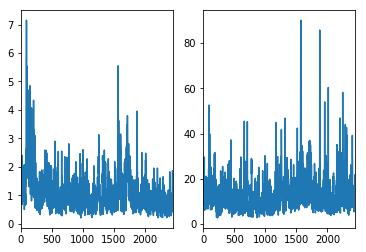

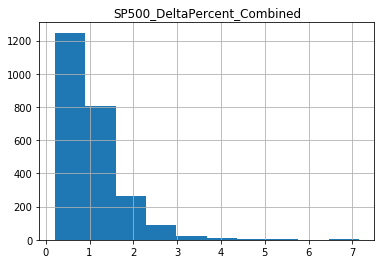

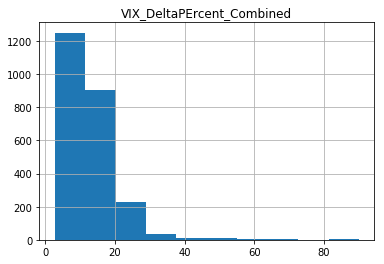

In [16]:
# graph distribution for SP500_DeltaPercent_Combined and VIX_DeltaPErcent_Combined

fig, axs = plt.subplots(1,2)
df_raw['SP500_DeltaPercent_Combined'].plot(ax=axs[0]);
df_raw['VIX_DeltaPErcent_Combined'].plot(ax=axs[1]);
df_raw.hist(column = 'SP500_DeltaPercent_Combined');
df_raw.hist(column = 'VIX_DeltaPErcent_Combined');

As we can see, both variables do not have normal distribution (see above), neither do the variables that were used to calculate them (see below), although OpenClose S&P500/VIX delta and percentage look closer to normal distribution. This, in part, is due to the fact that Combined percentages, as well as high/low deltas and percentages are always positive, based on the method of their calculation.

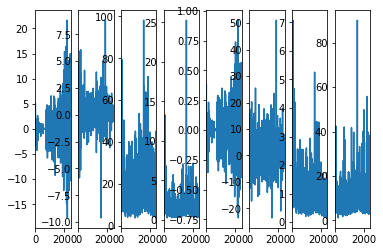

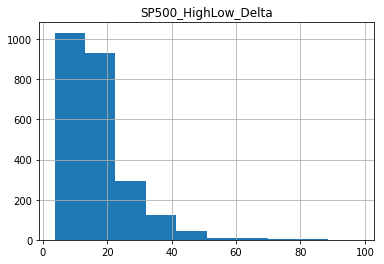

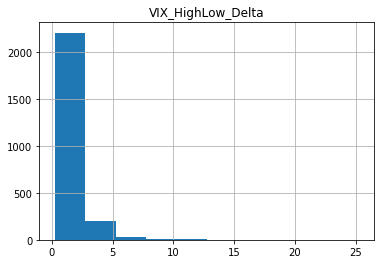

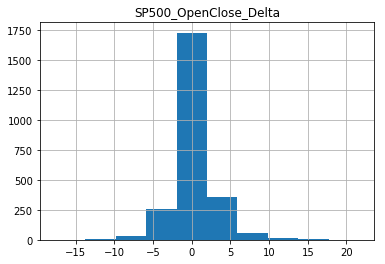

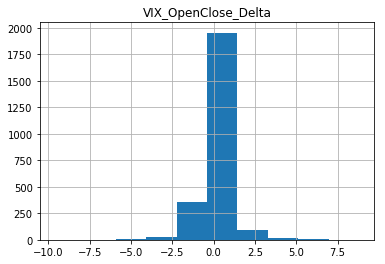

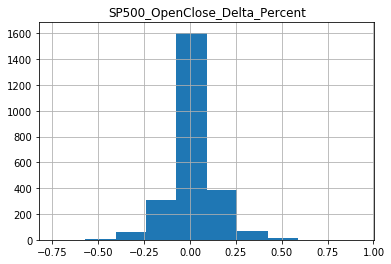

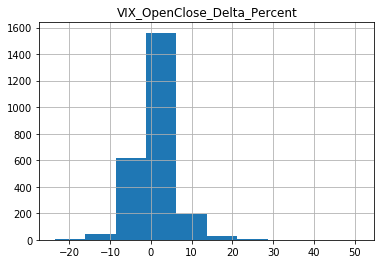

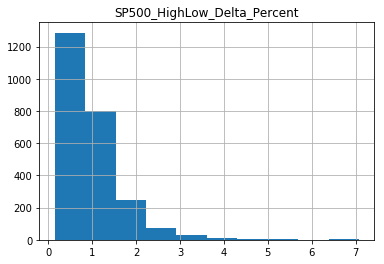

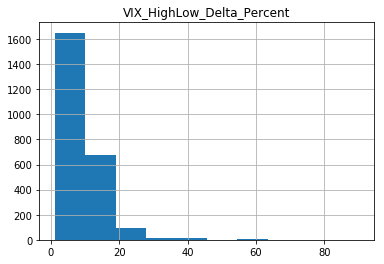

In [17]:
fig, axs = plt.subplots(1,8)
df_raw['SP500_OpenClose_Delta'].plot(ax=axs[0]);
df_raw['VIX_OpenClose_Delta'].plot(ax=axs[1]);
df_raw['SP500_HighLow_Delta'].plot(ax=axs[2]);
df_raw['VIX_HighLow_Delta'].plot(ax=axs[3]);
df_raw['SP500_OpenClose_Delta_Percent'].plot(ax=axs[4]);
df_raw['VIX_OpenClose_Delta_Percent'].plot(ax=axs[5]);
df_raw['SP500_HighLow_Delta_Percent'].plot(ax=axs[6]);
df_raw['VIX_HighLow_Delta_Percent'].plot(ax=axs[7]);
df_raw.hist(column = 'SP500_HighLow_Delta');
df_raw.hist(column = 'VIX_HighLow_Delta');
df_raw.hist(column = 'SP500_OpenClose_Delta');
df_raw.hist(column = 'VIX_OpenClose_Delta');
df_raw.hist(column = 'SP500_OpenClose_Delta_Percent');
df_raw.hist(column = 'VIX_OpenClose_Delta_Percent');
df_raw.hist(column = 'SP500_HighLow_Delta_Percent');
df_raw.hist(column = 'VIX_HighLow_Delta_Percent');

In [18]:
print "SP500_OpenClose_Delta normal distribution test:"
sy.stats.mstats.normaltest(df_raw['SP500_OpenClose_Delta'])

SP500_OpenClose_Delta normal distribution test:


NormaltestResult(statistic=432.01377679480743, pvalue=1.5466794521877241e-94)

In [19]:
print "VIX_OpenClose_Delta normal distribution test:"
sy.stats.mstats.normaltest(df_raw['VIX_OpenClose_Delta'])

VIX_OpenClose_Delta normal distribution test:


NormaltestResult(statistic=612.64341224440568, pvalue=9.2506733086473588e-134)

In [20]:
print "SP500_OpenClose_Delta_Percent normal distribution test:"
sy.stats.mstats.normaltest(df_raw['SP500_OpenClose_Delta_Percent'])

SP500_OpenClose_Delta_Percent normal distribution test:


NormaltestResult(statistic=310.91604754753877, pvalue=3.0580044106142384e-68)

In [22]:
print "VIX_OpenClose_Delta_Percent normal distribution test:"
sy.stats.mstats.normaltest(df_raw['VIX_OpenClose_Delta_Percent'])

VIX_OpenClose_Delta_Percent normal distribution test:


NormaltestResult(statistic=752.64416218180804, pvalue=3.6761799652864445e-164)

The normal distribution test for these variables does not reject the null hypothesis of the data coming from the normal distribution

In [23]:
# Let's review mean and standard deviation for SP500_DeltaPercent_Combined variable by each Mercury Retrograde Degree 
#and Federal Reserve Conference categories
print(df_raw.groupby('Mercury_Retrograde_Degree_Granular').SP500_DeltaPercent_Combined.agg(['mean', 'std']))
print(df_raw.groupby('Mercury_Retrograde_Degree_Colapsed').SP500_DeltaPercent_Combined.agg(['mean', 'std']))
print(df_raw.groupby('FedReserveConference').SP500_DeltaPercent_Combined.agg(['mean', 'std']))

                                        mean       std
Mercury_Retrograde_Degree_Granular                    
0                                   1.032527  0.611902
1                                   0.954739  0.588776
2                                   1.052873  0.588873
3                                   0.941329  0.641412
4                                   1.173445  0.569664
5                                   0.973518  0.747147
6                                   1.178869  0.613675
7                                   1.301709  1.107251
8                                   1.241687  0.827167
                                        mean       std
Mercury_Retrograde_Degree_Colapsed                    
0                                   1.032527  0.611902
1                                   1.004260  0.590326
2                                   1.057387  0.615881
3                                   1.086260  0.677962
4                                   1.301709  1.107251
5         

We can see that the highest SP500_DeltaPercent_Combined mean and STD values belong to Retrograde Itensified stage for both Mercury variables; the next highest - Retrograde state, followed by Station stages (Reverse station is slightly higher than the Direct station). Preshadow and Postshadow stages have lower values than the dates when Mercury is not in any retrograde stage.

As for the control FederalReserve Conference variable, the highest SP500_DeltaPercent_Combined belongs to unscheduled conferences, followed by scheduled summary conferences and scheduled regular conferences while the standard deviation is highest for scheduled regular conferences group.

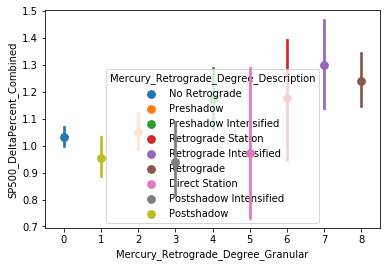

In [25]:
sns.pointplot(x="Mercury_Retrograde_Degree_Granular", y="SP500_DeltaPercent_Combined", hue="Mercury_Retrograde_Degree_Description", data=df_raw);

From the graph above, we see that the highest SP500_DeltaPercent_Combined values occur during Retrograde Itensified stage; the starting points for this variable are higher for this and Retrograde group than for any other, while the widest range of number occurs during the Direct Station stage. 

In [26]:
# Let's review mean and standard deviation for SP500_DeltaPercent_Combined variable by each Mercury Retrograde Degree 
#and Federal Reserve Conference categories
print(df_raw.groupby('Mercury_Retrograde_Degree_Granular').VIX_DeltaPErcent_Combined.agg(['mean', 'std']))
print(df_raw.groupby('Mercury_Retrograde_Degree_Colapsed').VIX_DeltaPErcent_Combined.agg(['mean', 'std']))
print(df_raw.groupby('FedReserveConference').VIX_DeltaPErcent_Combined.agg(['mean', 'std']))

                                         mean       std
Mercury_Retrograde_Degree_Granular                     
0                                   12.681385  7.699709
1                                   11.877125  5.629184
2                                   12.984471  5.867985
3                                   11.618087  5.270392
4                                   15.121715  7.502095
5                                   12.635531  8.097987
6                                   15.106300  7.641105
7                                   14.160867  9.382529
8                                   14.108086  8.129573
                                         mean       std
Mercury_Retrograde_Degree_Colapsed                     
0                                   12.681385  7.699709
1                                   12.435915  5.772267
2                                   13.369901  6.698118
3                                   13.992032  7.869212
4                                   14.160867  9

As we can see, Retrograde and Retrograde Itensified and Retrograde and Direct stations have higher averages and standard deviations than non-Retrograde while Post and Pre-shadows have means and deviations lower than those of non-Retrograde period. So, while there is a small shift in Mercury category rankings in this list, the general dynamic stays the same.

As for the control FederalReserve Conference variable, the highest VIX_DeltaPercent_Combined belongs to unscheduled conferences, followed by scheduled summary conferences and scheduled regular conferences while the standard deviation is highest for scheduled regular conferences group. The dynamic for this group is ghe same as with SP500_DeltaPercent_Combined variable.

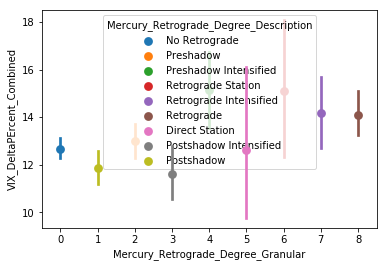

In [27]:
sns.pointplot(x="Mercury_Retrograde_Degree_Granular", y="VIX_DeltaPErcent_Combined", hue="Mercury_Retrograde_Degree_Description", data=df_raw);

From the graph above, we see that the highest VIX_DeltaPErcent_Combined values occur during Retrograde Station stage, although the values for Retrograde and Retrograde Itensified stage are also in the high range as they have the higher starting points; while the widest range of numbers occurs during the Direct Station stage. 

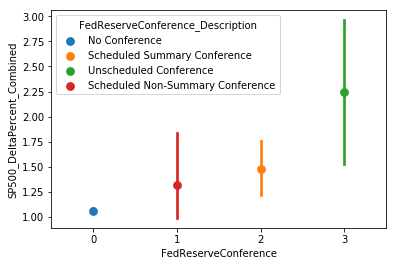

In [28]:
sns.pointplot(x="FedReserveConference", y="SP500_DeltaPercent_Combined", hue="FedReserveConference_Description", data=df_raw);

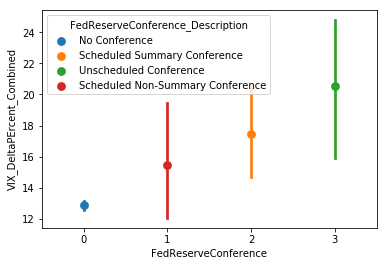

In [29]:
sns.pointplot(x="FedReserveConference", y="VIX_DeltaPErcent_Combined", hue="FedReserveConference_Description", data=df_raw);

As we can see from the two graphs above, Uncheduled Conference category has the highest VIX_DeltaPErcent_Combined values while some of the values for the Scheduled Non-Summary Conference are the lowest across all categories, attributing to the fact that this category has the highest deviation.

Overall, the matimatical analysis of the dataset indicates that S&P 500 data has a dynamic for larger movement (percentage-wise) between Open and previous days' Close, as well as the day's Low and High during the time between Mercury Retrograde and Direct Station dates.